# Group Details
## Group 15 


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def load_trajectory(filename, task):

    traj = np.load(filename)
    if task == 'task_1' or task == 'task_2':
        trajectory = traj['trajectory']
        energy = traj['energy']
        return trajectory, energy
    if task == 'task_3':
        trajectory = traj['trajectory']
        framework = traj['framework']
        energy = traj['energy']
        return trajectory, framework, energy

Below, you can find an example of how to load a trajectory. ```trajectory``` contains the particle position, velocity and charge data. ```energy``` contains the energy of the system at various timesteps. The shape of the arrays is as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

In [5]:
trajectory, energy = load_trajectory('data_A2_2AMM10_2023_2024/data/task1_2/train/trajectory_0.npz', 'task_1')
print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory. Feel free to modify this code, or write your own function. When evaluating your model in task 2 and 3, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

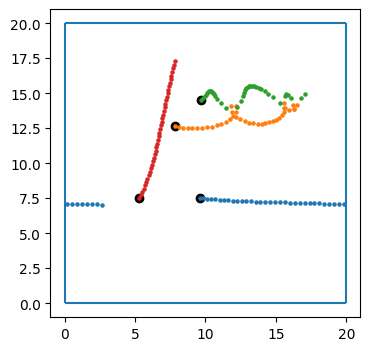

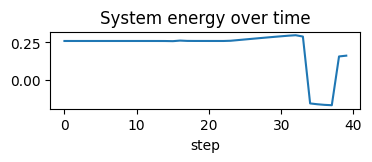

In [6]:
x = trajectory[...,0]
y = trajectory[...,1]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

# Task 1

Implement task 1 below. Feel free to add extra code cells for different components of your implementation.

In [7]:
# !pip install 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.optimizers import Adam

# Task 2

Implement task 2 below. Feel free to add extra code cells for different components of your implementation.

In [9]:
train_trajectory = np.load('data_A2_2AMM10_2023_2024/data/task1_2/train/trajectory_0.npz')['trajectory']


After predicting energies, the next step towards building a simulator is modelling the dynamics. Specifically, your task is to build a model, that, given a set of initial positions x0 i, velocities v0 i and charges qi of atoms pi, predicts a sequence of positions x1:T i state of T = 40. The length of each time step is 0.5 seconds.
 , up to terminal
 For this task, the training data consists of the same data as in the previous task. The test
 set consists of datapoints containing initial positions x0
 i and velocities v0
 i and charges qi, as
 well as the energy e0, paired with the remainder of the trajectories x1:T
 i
 evaluating the performance of your method.
 Hints:
 of the atoms pi for
 • While building a model, keep in mind how your design choices affect the ability of your
 model to handle symmetries. What will happen to the trajectory if the initial positions
 and velocities are rotated? What will happen if they are reflected horizontally?
 • We only care about the performance of your model with respect to the predicted
 positions for its evaluation. However, depending on your approach, it might be useful
 to also have your model predict velocities and energies in order to infer positions later
 on.
 • Whenperforming the evaluation of your model, keep in mind that you are only allowed
 to give it as input x0
 i, v0
 i, e0. The rest of the trajectory needs to be generated by your
 model!



In [10]:
# Prepare the data for training 

# Initial positions at t=0
initial_positions = trajectory[:, 0, :]
# Initial velocities estimated from the difference in positions between t=1 and t=0
initial_velocities = (trajectory[:, 1, :] - trajectory[:, 0, :]) / 0.5  # Assuming time step is 0.5s
# Generate charges for the atoms (for simplicity, using random charges)
charges = np.random.choice([-1, 1], size=(trajectory.shape[0], trajectory.shape[1]))


In [14]:
x_train

array([[ 0.4797772 ,  0.3765976 ,  0.02632263, -0.00332456,  0.05      ],
       [ 0.39213811,  0.63270296,  0.02790615, -0.00555387,  0.05      ],
       [ 0.48560674,  0.72478866,  0.01326539,  0.01580268,  0.05      ],
       [ 0.26401827,  0.37680233,  0.01214412,  0.02124722,  0.05      ]])

In [13]:
# Prepare the data for training 
# Initial positions at t=0
initial_positions = trajectory[0, :, :2]
# Initial velocities estimated from the difference in positions between t=1 and t=0
initial_velocities = (trajectory[1, :, :2] - trajectory[0, :, :2]) / 0.5  # Assuming time step is 0.5s
# Generate charges for the atoms (for simplicity, using random charges)
charges = np.random.choice([-1, 1], size=(initial_positions.shape[0], 1))
# Prepare data
x_train = np.concatenate([initial_positions, initial_velocities, charges], axis=-1)
y_train = trajectory[1:, :, :2].reshape(trajectory.shape[0] - 1, -1)

# Normalize positions and velocities
x_train = x_train / 20.0
y_train = y_train / 20.0

# Define the LSTM model
model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(initial_positions.shape[0] * 2))  # Predicting 2 coordinates for each atom

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Predict the sequence of positions for test data
test_trajectory, test_energy = load_trajectory('data_A2_2AMM10_2023_2024/data/task3/test/trajectory_900.npz', 'task_2')
test_initial_positions = test_trajectory[0, :, :2]
test_initial_velocities = (test_trajectory[1, :, :2] - test_trajectory[0, :, :2]) / 0.5

test_x = np.concatenate([test_initial_positions, test_initial_velocities, charges[:test_initial_positions.shape[0]]], axis=-1)
test_x = test_x / 20.0

predicted_positions = model.predict(test_x)

# Reshape the predicted positions back to the original format
predicted_positions = predicted_positions * 20.0  # Re-scale back to original dimensions
predicted_positions = predicted_positions.reshape(test_trajectory.shape[0] - 1, -1, 2)

print(predicted_positions)

Epoch 1/100
1/1 [==============================] - 1s 579ms/step - loss: 0.2482 - val_loss: 0.2428
Epoch 2/100
1/1 [==============================] - 0s 96ms/step - loss: 0.2246 - val_loss: 0.2264
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2023 - val_loss: 0.2103
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1814 - val_loss: 0.1949
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.1614 - val_loss: 0.1805
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1429 - val_loss: 0.1664
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 0.1258 - val_loss: 0.1525
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1095 - val_loss: 0.1393
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0943 - val_loss: 0.1267
Epoch 10/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0805 - val_loss: 0.1145
Epoch 11/100
1/1 [

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 5 and the array at index 2 has size 4

# Task 3

In task 3, you also need to model the influences of the crystal. An example of loading a trajectory can be found below. The trajectory and energy data has the same shape as before, however, data regarding the crystal has been added. Since atoms belonging to the crystal do not move, this data does not have a time dimension when loaded. The shapes of the arrays are as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

```framework```:```(n_framework_atom, [x, y, q])```



In [5]:
trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory with a crystal. Feel free to modify this code, or write your own function. When evaluating your model in this task, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

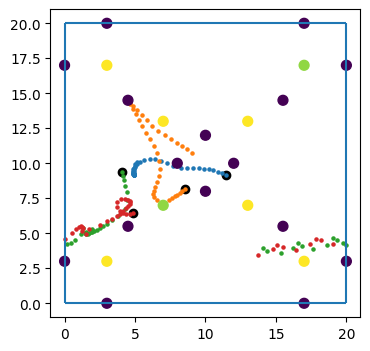

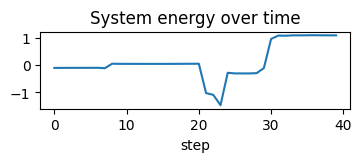

In [6]:
x = trajectory[...,0]
y = trajectory[...,1]

x_fw = framework[...,0]
y_fw = framework[...,1]
q_fw = framework[...,2]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.scatter(x_fw, y_fw, c=q_fw, cmap='viridis', s=50)
# to also visualize the framework points along the boundaries
plt.scatter(x_fw+20, y_fw, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw, y_fw+20, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw+20, y_fw+20, c=q_fw, cmap='viridis', s=50)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

Implement task 3 below. Feel free to add extra code cells for different components of your implementation.